In [1]:
import numpy as np
from PIL import Image, ImageDraw
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# CNN
import tensorflow as tf
from tensorflow.keras.applications import InceptionResNetV2  # Using Inception V4
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

### Labelling the dataset

In [3]:
def load_images_and_labels(base_path, label_mapping, img_size=(200, 200)):
    images = []
    labels = []
    
    # Iterate through all files in the specified directory
    for filename in os.listdir(base_path):
        if filename.endswith('.png'):  # Check for PNG files
            img_path = os.path.join(base_path, filename)
            img = load_img(img_path, target_size=img_size)

            img_array = img_to_array(img)
            img_array = np.asarray(img_array).astype(np.float32)
            img_array = img_to_array(img) / 255.0  # Normalize pixel values
            
            macro_object = filename.split('_')[0]  # Extract the macro-object type
            label = label_mapping.get(macro_object)  # Use .get() to avoid KeyError
            
            if label is None:
                raise ValueError(f"Label for macro_object '{macro_object}' not found in label_mapping.")
            
            images.append(img_array)
            labels.append(label)
    
    return np.array(images), np.array(labels)

In [5]:
label_mapping = {'circle': 0, 'square': 1}

# Load the training dataset
X_train, y_train = load_images_and_labels('/closure_dataset/train_dataset', label_mapping)
# One-hot encode the labels
y_train_one_hot = to_categorical(y_train, num_classes=len(label_mapping))

# Load the validation dataset
X_valid, y_valid = load_images_and_labels('/closure_dataset/val_dataset', label_mapping)
# One-hot encode the labels
y_valid_one_hot = to_categorical(y_valid, num_classes=len(label_mapping))

# Load the test dataset
X_test, y_test = load_images_and_labels('/closure_dataset/test_dataset', label_mapping)
# One-hot encode the labels
y_test_one_hot = to_categorical(y_test, num_classes=len(label_mapping))

In [6]:
print("Train_dataset shape:" , X_train.shape)
print("Valid_dataset shape:" , X_valid.shape)
print("Test_dataset shape:" , X_test.shape)

Train_dataset shape: (1000, 200, 200, 3)
Valid_dataset shape: (1000, 200, 200, 3)
Test_dataset shape: (1000, 200, 200, 3)


### Training InceptionV4

In [8]:
def build_inceptionV4(input_shape):
    input_tensor = Input(shape=input_shape)

    base_model = InceptionResNetV2(input_tensor=input_tensor, weights='imagenet', include_top=False)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(2, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=predictions)
    
    return base_model, model

In [9]:
nb_epoch2 = 10
train_sample_len = len(X_train)

base_model, model = build_inceptionV4(input_shape=(200, 200, 3))

219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [10]:
datagen = ImageDataGenerator(
        preprocessing_function=None,
        rotation_range=5,
        width_shift_range=0.02,
        height_shift_range=0.02,
        horizontal_flip=True,
        vertical_flip=True
    )

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
model_str = f"proximity_incep4-{{epoch:02d}}-{{val_accuracy:.3f}}.weights.h5"
filepath2 = f"models/{model_str}"
checkpoint2 = ModelCheckpoint(filepath2, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max', save_weights_only=True)

early_stopper = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=40)

callbacks_list2 = [early_stopper, checkpoint2]

In [12]:
# Train the model
steps_per_epoch = train_sample_len // 100  
model.fit(datagen.flow(X_train, y_train_one_hot, batch_size=40, shuffle=True),
              steps_per_epoch=steps_per_epoch,
              epochs=nb_epoch2,
              validation_data=(X_valid, y_valid_one_hot),
              callbacks=callbacks_list2)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1729727302.420876      77 service.cc:145] XLA service 0x7f3b00003200 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729727302.420927      77 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729727302.420932      77 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1729727365.994748      77 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 ━━━━━━━━━━━━━━━━━━━━ 157s 3s/step - accuracy: 0.6427 - loss: 1.9402 - val_accuracy: 0.5170 - val_loss: 26.7254
Epoch 2/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 995ms/step - accuracy: 0.9979 - loss: 0.0216 - val_accuracy: 0.8110 - val_loss: 0.2796
Epoch 3/10
 5/10 ━━━━━━━━━━━━━━━━━━━━ 2s 439ms/step - accuracy: 0.9938 - loss: 0.0109

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 757ms/step - accuracy: 0.9919 - loss: 0.0134 - val_accuracy: 0.9910 - val_loss: 0.0852
Epoch 4/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 1.0000 - loss: 4.9697e-04 - val_accuracy: 0.9930 - val_loss: 0.0448
Epoch 5/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 1.0000 - loss: 2.0568e-04 - val_accuracy: 0.9960 - val_loss: 0.0259
Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 774ms/step - accuracy: 1.0000 - loss: 1.4512e-04 - val_accuracy: 0.9980 - val_loss: 0.0201
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 1.0000 - loss: 1.5999e-04 - val_accuracy: 0.9990 - val_loss: 0.0121
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 838ms/step - accuracy: 1.0000 - loss: 1.0325e-04 - val_accuracy: 0.9990 - val_loss: 0.0082
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 585ms/step - accuracy: 1.0000 - loss: 3.7473e-05 - val_accuracy: 0.9990 - val_loss: 0.0072
Epoch 10/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 856ms/step - accuracy: 1.0000 - loss: 3.3760e-05 - val

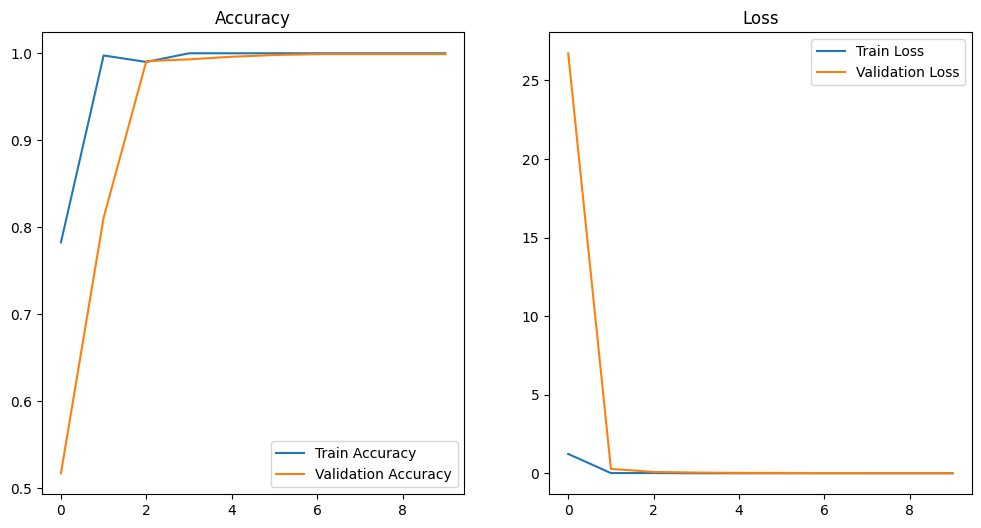

In [13]:
# Plot training progress
history = model.history.history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
    
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.show()

The model is performing quite well as it has reached a training accuracy of nearly 100% and a validation accuracy of 99.9% by the 10th epoch.

In [14]:
training_model_weights = model.get_weights()
print("Model weights saved to a variable.")

Model weights saved to a variable.


### Testing InceptionV4

In [15]:
base_model, model_test = build_inceptionV4(input_shape=(200, 200, 3))

In [16]:
print('loading weights: ')
model_test.set_weights(training_model_weights)

loading weights: 


In [17]:
preds = model_test.predict(X_test, verbose=0)

In [18]:
# Convert one-hot encoded labels to class indices
y_true_indices = np.argmax(y_test_one_hot, axis=1)
y_pred_indices = np.argmax(preds, axis=1)

In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

In [20]:
# Calculate accuracy
accuracy = accuracy_score(y_true_indices, y_pred_indices)

# Calculate precision and recall (average='macro' for multi-class)
precision = precision_score(y_true_indices, y_pred_indices, average='macro')
recall = recall_score(y_true_indices, y_pred_indices, average='macro')

# Output the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.9980
Precision: 0.9980
Recall: 0.9980


In [21]:
ilm = {0: 'circle', 1: 'square'}

In [22]:
# Calculate precision and recall for each class
precision_per_class = precision_score(y_true_indices, y_pred_indices, average=None)
recall_per_class = recall_score(y_true_indices, y_pred_indices, average=None)

# Output the metrics for each class
for i, (precision, recall) in enumerate(zip(precision_per_class, recall_per_class)):
    print(f"Class {ilm[i]}: Precision = {precision:.4f}, Recall = {recall:.4f}")

Class circle: Precision = 1.0000, Recall = 0.9961
Class square: Precision = 0.9959, Recall = 1.0000


We can see that the model has learned the closure principle quite well as it has a **test accuracy of 99.8%** , along with near perfect precision and recall scores for both classes.